# HISTOGRAM MATCHING
[wiki](https://en.wikipedia.org/wiki/Histogram_matching)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
%matplotlib inline
import sys,cv2
sys.path.append("/home/msmith/kaggle/cifar10/")
from unpickle import unpickle
import histMatch
from ggplot import *
import pandas as pd

In [2]:
dataPaths = glob.glob("/home/msmith/kaggle/whale/imgs/*/w1S*") # whales
n = 100
sampleIdx = np.random.permutation(len(dataPaths))[:n]
sample = [dataPaths[i] for i in sampleIdx]
medianIntensities = np.zeros(n)
for i in xrange(n):
    img = cv2.imread(sample[i],0)
    medianIntensities[i] = np.median(img)
    
sortedIndices = medianIntensities.argsort()[::20]

In [3]:
arrToDf = lambda arr: pd.DataFrame(arr.flatten(),columns=["intensity"])
def subSetDf(df,col,val):
    return df.loc[df[col]==val]

In [4]:
xLab = "Pixel intensity"
yLab = "Percentage of total mass"
def plotHist(src,dst,base,bw=2):
    df1 = arrToDf(src)
    df2 = arrToDf(dst)
    df3 = arrToDf(base)
    df = pd.concat([df1,df2,df3],0).reset_index(drop=True)
    labels= pd.Series(np.repeat(["Source","Destination","Target"],df.shape[0]/3))
    df["labels"] = labels
    df["labels"]= df["labels"].apply(str)
    df.columns = ["Pixel Value","labels"]
    df = df.iloc[np.random.permutation(df.shape[0])][:20000] # get random subset otherwise takes way too long
    gplot = ggplot(aes(x="Pixel Value"),data=df) + \
    geom_density(data=subSetDf(df,"labels","Source"),color="red") +  \
    geom_density(data=subSetDf(df,"labels","Destination"),color="green") +  \
    geom_density(data=subSetDf(df,"labels","Target"),color="blue") +  \
    xlim(0,170) + ylab(yLab) + xlab(xLab)
    return gplot

True

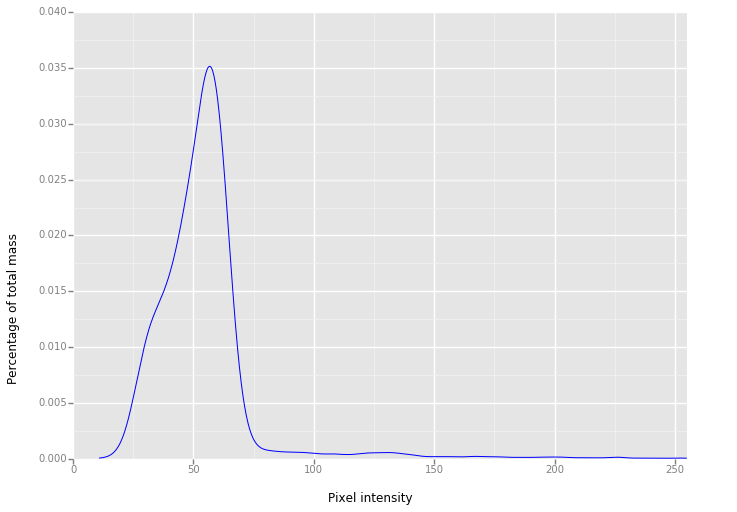

In [5]:
base = cv2.imread("/home/msmith/kaggle/whale/locator/augmented/histMatchBase/x_1.jpg")[:,:,::-1]
baseDf = arrToDf(base)
baseDf = baseDf.iloc[np.random.permutation(baseDf.shape[0])][:20000]
gBase = ggplot(aes(x="intensity"),data=baseDf) + \
    geom_density(color="blue") + xlim(0,255) + ylab(yLab) + xlab(xLab) 
gBase.save("examples/base.pdf")
cv2.imwrite("examples/base.jpg",base[:,:,::-1])

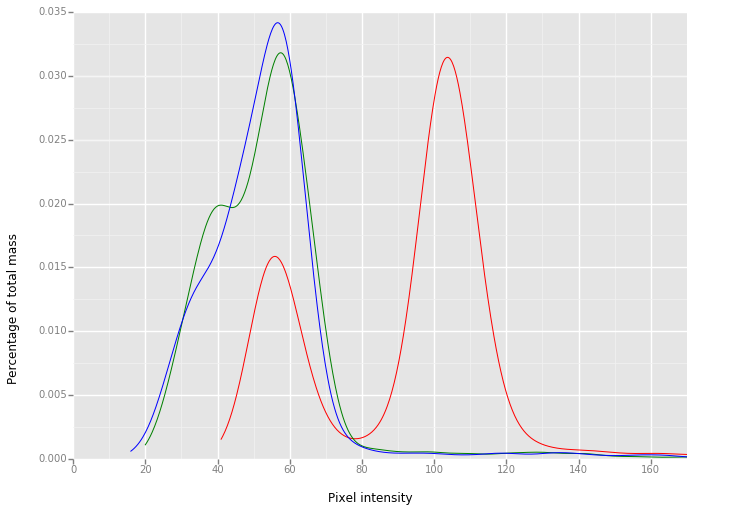

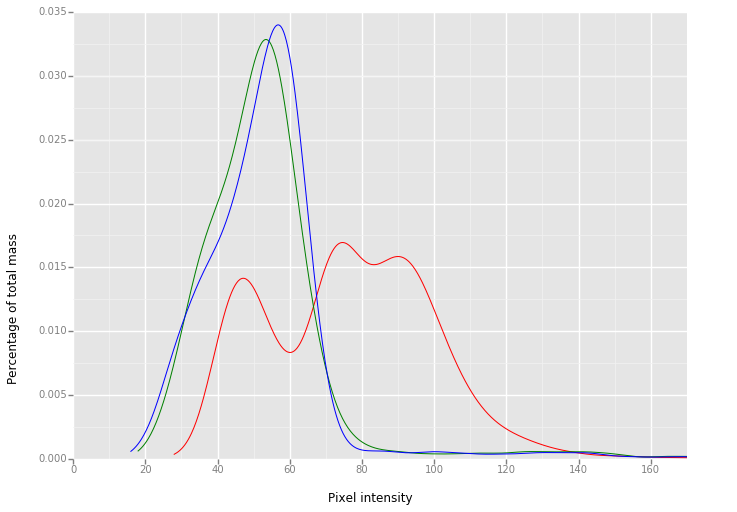

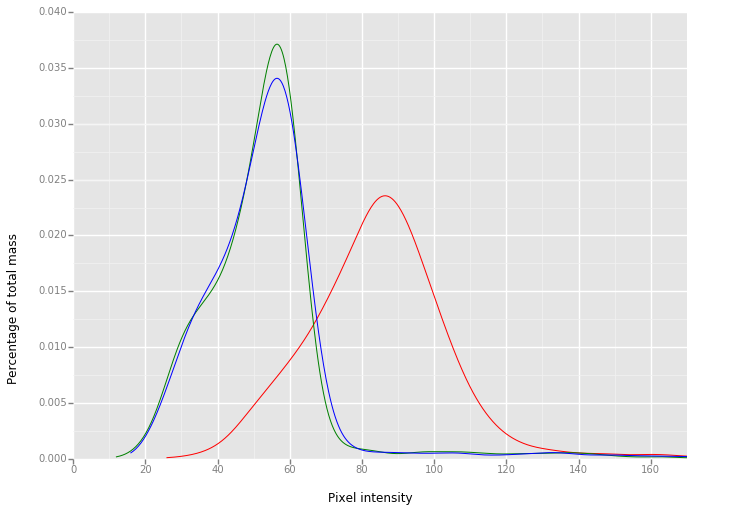

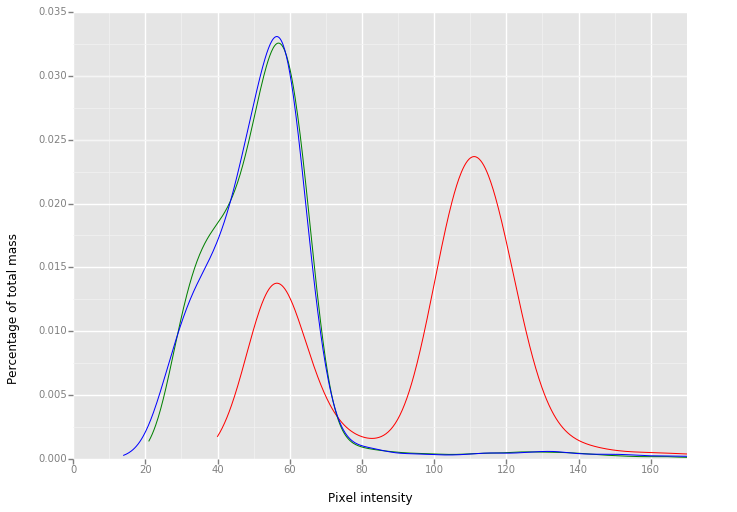

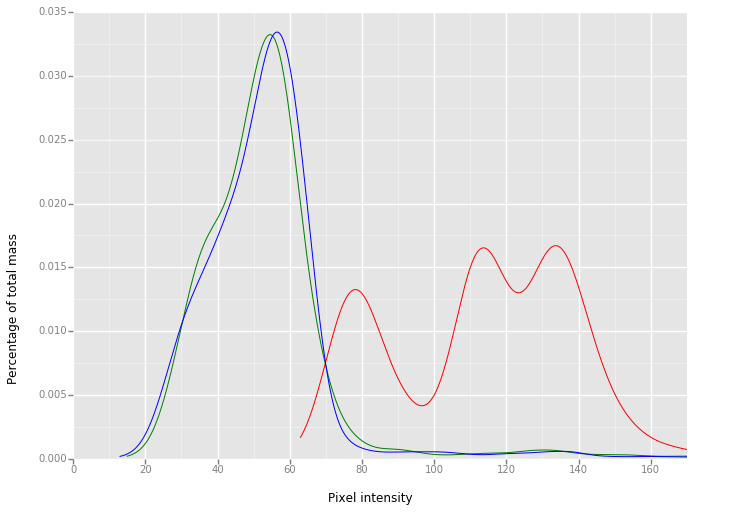

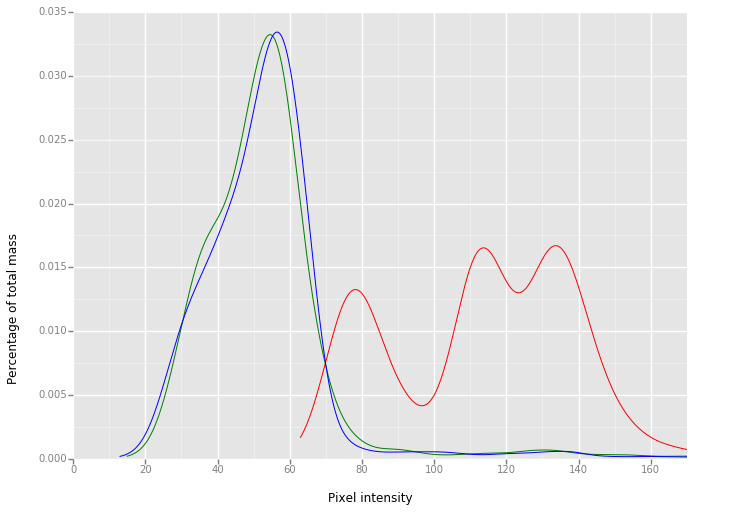

In [9]:
h = base.shape[0]
sep = np.zeros((h,100,3)).astype(np.uint8)
sep.fill(255)
name = 0
for i in sortedIndices[:]:
    if name == 0:
        src = cv2.imread('/home/msmith/kaggle/whale/imgs/test/w1S_0.jpg')
    else:
        src = cv2.imread(sample[i])
    src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
    dst,mappings = histMatch.histMatchAllChannels(src,base)
    gplt = plotHist(src,dst,base,bw=2)
    gplt.show()
    gplt.save("examples/{0}_hists.jpg".format(name))
    both = np.hstack((src,sep,dst,sep,base))
    cv2.imwrite("examples/{0}_imgs.jpg".format(name),cv2.cvtColor(both,cv2.COLOR_RGB2BGR))
    name+=1

In [ ]:
from histMatch import brgToYuv, cdfImg
yBase, ySrc = [brgToYuv(x)[:,:,0] for x in [base,src]]
uBase, uSrc = [brgToYuv(x)[:,:,1] for x in [base,src]]
vBase, vSrc = [brgToYuv(x)[:,:,2] for x in [base,src]]

In [ ]:
yBaseCdf, uBaseCdf, vBaseCdf, ySrcCdf, uSrcCdf, vSrcCdf = [cdfImg(x)[1] for x in [yBase,uBase,vBase,ySrc,uSrc,vSrc]]

#cdfBase, cdfSrc = [x.astype(np.float32)/x.sum() for x in [cdfBase, cdfSrc]]

In [ ]:
def cdfDf(x):
    df = pd.DataFrame({
        'Pixel value' : np.arange(x.size),
        'cdf': x
    })
    return df

yBaseCdf, uBaseCdf, vBaseCdf, ySrcCdf, uSrcCdf, vSrcCdf = [cdfDf(x) for x in [yBaseCdf, uBaseCdf, vBaseCdf, ySrcCdf, uSrcCdf, vSrcCdf]]